# FBA/$\epsilon$ water model

References :
* Original paper : https://www.if.ufrgs.br/~barbosa/Publications/Physics/fuentes-azcatl-JML-2020.pdf
* Analytical expressions for the forces : https://manual.gromacs.org/documentation/current/reference-manual/functions/functions.html
* Simulation reference : https://www.nist.gov/programs-projects/nist-standard-reference-simulation-website

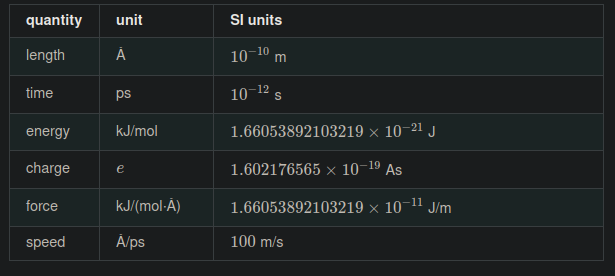

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib_tufte import *
setup()

from md import *

In [3]:
# TODO : save mp4
# sys = System.load_NIST('data/nist_SPC_E_water_data/spce_sample_config_periodic1.txt')
# plot_rotating(sys, frames=360, interval=30)

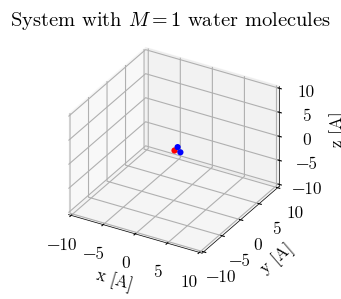

In [4]:
sys = System.load_NIST('data/debug5.txt')
plot_sys(sys);
plt.show()

In [18]:
sim = Simulation(
	integ=LeapFrog(dt=1e-3),  # 1 fs
	ff=FBAeps(),
	sys=System.load_NIST('data/debug1.txt'),
	# T=298.15
	T=0
)
res = sim.run(10000, accumulate={'t', 'x',
	'potential_total', 'potential_LJ', 'potential_elec', 'potential_bond', 'potential_bend',
	'total_energy',
	'kinetic_energy',
	'temperature',
})

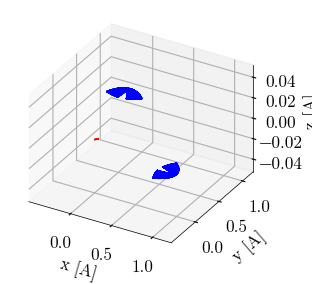

In [19]:
plot_xyz_trajectory(res);

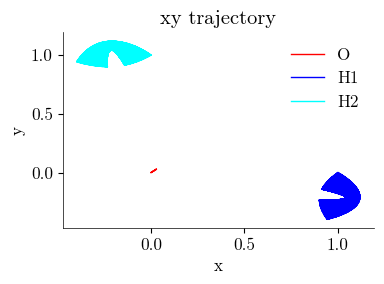

In [21]:
plot_xy_trajectory(res);

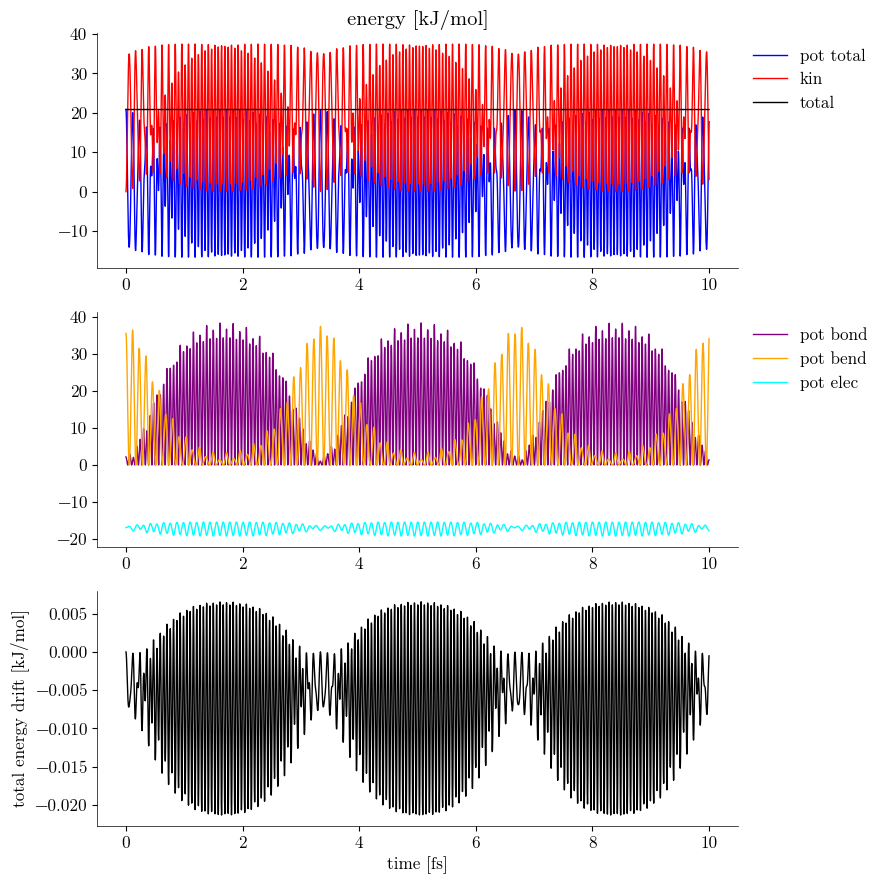

In [22]:
plot_energy(res);

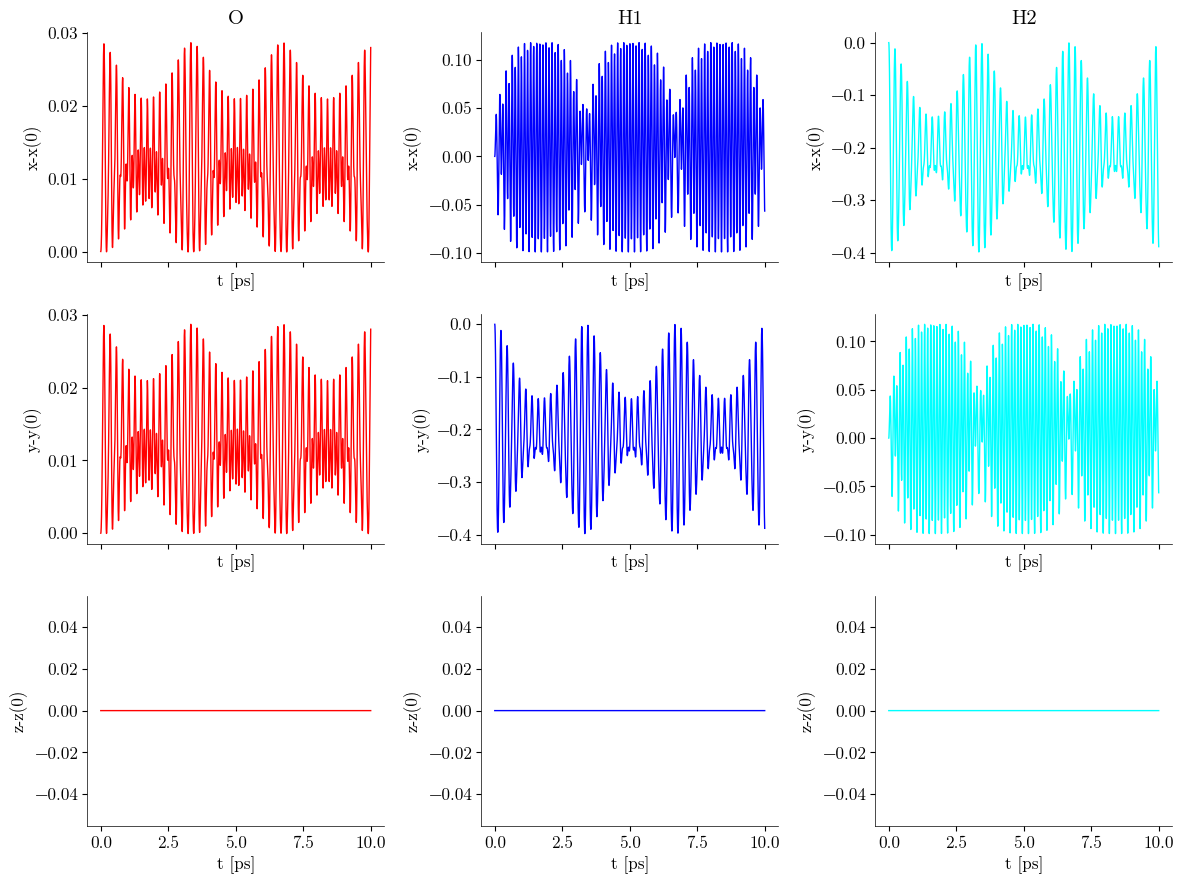

In [23]:
plot_coord_trajectory(res);

NOTE : leapfrog should conserve energy, but here is does not. this is because the harmonic bending force does NOT derive from a potential !!

TODO : study transfer of vibrational nodes between bond and bend